# Classification Example

In [1]:
import os
import sys
from base64 import b64encode

import pathlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import albumentations as albu

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-14mjotfm because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Require 24 GB of GPU RAM

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [
                tf.config.experimental.VirtualDeviceConfiguration(
                    memory_limit=1024 * 24
                )
            ],
        )
    except RuntimeError as e:
        print(e)


Download and setup dataset

In [3]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

Import swiss_army keras lib

In [4]:
#Uncomment to install dependencies, if needed
#!pip3 install --upgrade git+https://github.com/waterviewsrl/swiss-army-keras.git
#!pip3 install typeguard
#!pip3 install --upgrade irondomo
#!pip3 install --upgrade pillow
#!pip3 install --upgrade adabelief_tf
from swiss_army_keras.dataset_utils import ClassificationAlbumentationsDataLoader

from swiss_army_keras import models, base, utils, losses, optimizers


Define input tensor and build classifier model with default MobileNetV3Large minimalistic backbone

This model (distiller) defines a top classification layer which tries to go beyond the usual GlobalPooling + Dense layer, by preserving information about spatial relation of macrofeatures in the last convolutional layer output.   

In [5]:
inp = tf.keras.layers.Input(shape=(512, 512, 3), batch_size=1)

model = models.distiller_classifier(inp, 5, macrofeatures_number=5, size=256)


Define augmentation pipeline (see https://albumentations.ai/docs/) 

In [6]:
def get_training_augmentation(width=512, height=512):
    train_transform = [
        

        #albu.RandomRotate90(p=0.5),
        
        #albu.OneOf([
        #   
        #   
        #], p=1),
        #albu.Resize(width, height, 2, p=1),

        #albu.ShiftScaleRotate(shift_limit = 0.05, scale_limit=(0.1, 0.1), interpolation=2, rotate_limit=25, p=0.3),
        
        albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.15),

        albu.Compose([
        albu.OneOf([
            albu.ISONoise(p=1),
            albu.MultiplicativeNoise(p=1),
            albu.GaussNoise(p=1),
            albu.ImageCompression(p=1),

            ], 
            p=0.2,
        ),
        
        #albu.Perspective(pad_mode=2, p=0.1),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.Sharpen(p=1),
                albu.Emboss(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=5, p=1),
                albu.MedianBlur(blur_limit=5, p=1),
                albu.MotionBlur(blur_limit=5, p=1),
            ],
            p=0.25,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.RGBShift(p=1),
            ],
            p=0.25,
        ),
        
        albu.OneOf(
            [
                #albu.ElasticTransform(alpha=10, sigma=10 * 0.05, alpha_affine=10 * 0.03, p=0.5),
                albu.GridDistortion(p=0.5),
                albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.05, p=1)      
            ],
            p=0.25,
        )], p=0.5),
        
        #DropsOnLens(maxR=40, minR=30, p=0.1),
        albu.ToGray(p=0.2)
    ]
    
    return albu.Compose(train_transform)
    #return albu.Compose([])


Initialize classification dataloader 

This will create a number of workers equal to half the number of CPU cores on the machine. These workers will produce random augmentations according to the defined pipeline, so that at each epoch every batch will change.

<u>Please note:</u>
Passing normalization=model.preprocessing grants that the correct normalization is applied in a consistent way during training, evaluation and quantization.

<u>Please note:</u> This will produce a lot of output, depending also on the number of CPUs, to monitor workers connectivity and liveliness

In [7]:
dl = ClassificationAlbumentationsDataLoader(str(flowers_root), width=512, height=512, train_augmentations=get_training_augmentation(), batch_size=16, normalization=model.preprocessing)

Class label daisy will have id: 0
Class label dandelion will have id: 1
Class label roses will have id: 2
Class label sunflowers will have id: 3
Class label tulips will have id: 4
train_val_test_split: [2936, 367, 367]


Define train val and test sets

In [8]:
train_set, val_set, test_set = dl.build_datasets()

View a batch of augmentetd images from train set

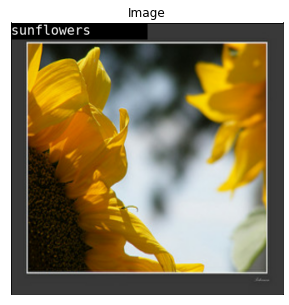

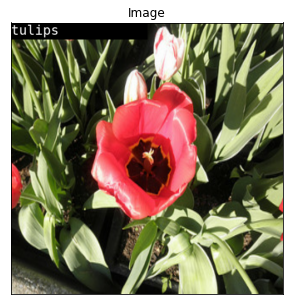

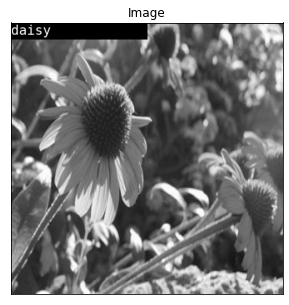

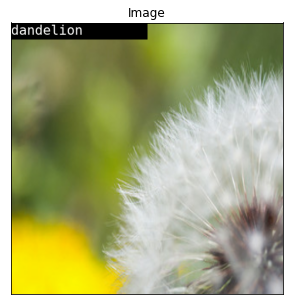

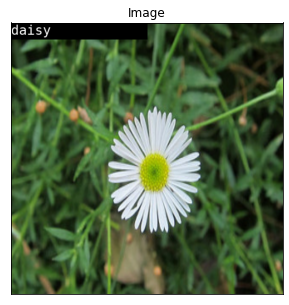

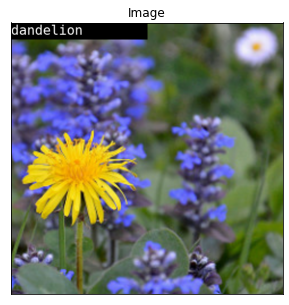

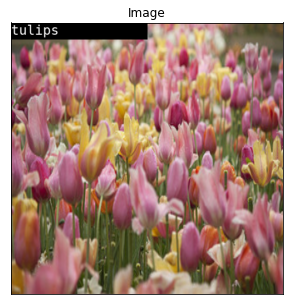

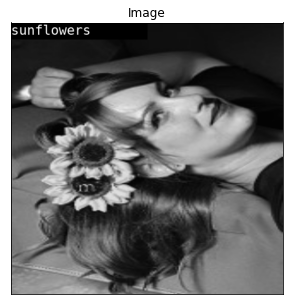

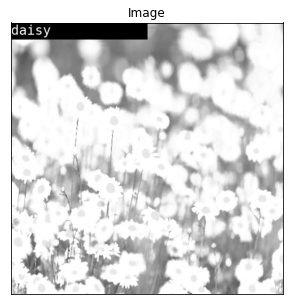

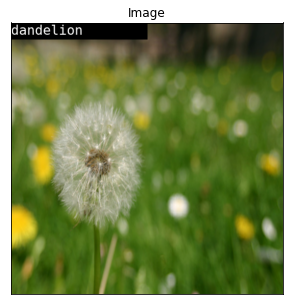

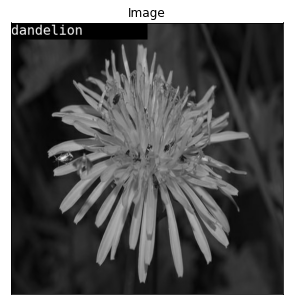

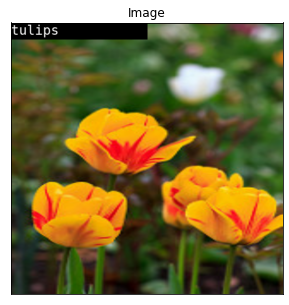

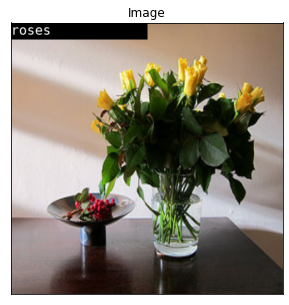

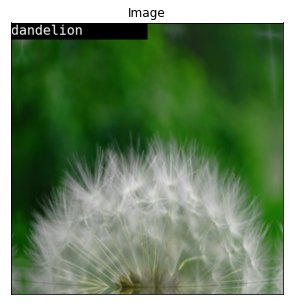

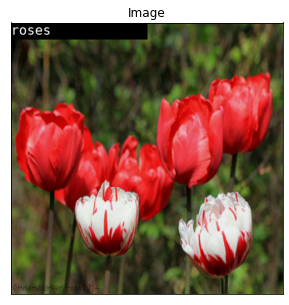

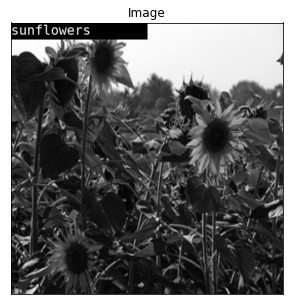

In [9]:
dl.show_images(16)

In [10]:
from adabelief_tf import AdaBeliefOptimizer
from swiss_army_keras.training_utils import TrainingDriver

In [11]:
accuracy = tf.keras.metrics.CategoricalAccuracy()

Train for 40 eochs (20 with frozen backend + 20 with unfrozen backend) with the desired optimizer, loss and metrices.

This will also produce h5 model, f16 and ui8 quantized models, metrics and loss history graphs, all named according to the name (prova_multi in this case) + startup datetime.

<u>Please Note:</u> TrainingDriver implicitly defines callbacks for ModelCheckpoint and for EarlyStopping with 15 epochs patience. The saved models, quantized and not, corresponds to the best validation loss found during training. 


In [12]:
td = TrainingDriver(model, 'prova_multi', AdaBeliefOptimizer(learning_rate=1e-4, epsilon=1e-14, rectify=True), tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), [accuracy], train_set, val_set, test_set, 20 )
td.run()

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Model: "model"
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


183/183 [==============================] - ETA: 0s - loss: 2.0143 - categorical_accuracy: 0.5249WARNING:tensorflow:Model was constructed with shape (1, 512, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (16, 512, 512, 3).


183/183 [==============================] - 16s 55ms/step - loss: 2.0143 - categorical_accuracy: 0.5249 - val_loss: 1.8842 - val_categorical_accuracy: 0.6591
Epoch 2/20
183/183 [==============================] - 10s 50ms/step - loss: 1.6382 - categorical_accuracy: 0.7510 - val_loss: 1.4155 - val_categorical_accuracy: 0.8040
Epoch 3/20
183/183 [==============================] - 10s 52ms/step - loss: 1.2311 - categorical_accuracy: 0.8463 - val_loss: 1.1303 - val_categorical_accuracy: 0.8438
Epoch 4/20
183/183 [==============================] - 10s 51ms/step - loss: 1.0534 - categorical_accuracy: 0.8736 - val_loss: 1.0248 - val_categorical_accuracy: 0.8551
Epoch 5/20
183/183 [==============================] - 10s 54ms/step - loss: 0.9722 - categorical_accuracy: 0.8863 - val_loss: 0.9528 - val_categorical_accuracy: 0.8693
Epoch 6/20
183/183 [==============================] - 10s 53ms/step - loss: 0.9048 - categorical_accuracy: 0.8975 - val_loss: 0.8957 - val_categorical_accuracy: 0.8807
Epo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
MobileNetV3Large_backbone (Func [(1, 256, 256, 64),  1437608     input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (1, 5, 5, 960)       0           MobileNetV3Large_backbone[0][4]  
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (1, 1, 1, 960)       24960       average_pooling2d[0][0]          
______________________________________________________________________________________________

183/183 [==============================] - ETA: 0s - loss: 0.7263 - categorical_accuracy: 0.9095WARNING:tensorflow:Model was constructed with shape (1, 512, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (16, 512, 512, 3).


183/183 [==============================] - 63s 244ms/step - loss: 0.7263 - categorical_accuracy: 0.9095 - val_loss: 0.8143 - val_categorical_accuracy: 0.8608
Epoch 2/20
183/183 [==============================] - 42s 226ms/step - loss: 0.6166 - categorical_accuracy: 0.9611 - val_loss: 0.7439 - val_categorical_accuracy: 0.8807
Epoch 3/20
183/183 [==============================] - 41s 223ms/step - loss: 0.5775 - categorical_accuracy: 0.9775 - val_loss: 0.6824 - val_categorical_accuracy: 0.9062
Epoch 4/20
183/183 [==============================] - 41s 224ms/step - loss: 0.5598 - categorical_accuracy: 0.9843 - val_loss: 0.6625 - val_categorical_accuracy: 0.9091
Epoch 5/20
183/183 [==============================] - 41s 224ms/step - loss: 0.5425 - categorical_accuracy: 0.9870 - val_loss: 0.6520 - val_categorical_accuracy: 0.9006
Epoch 6/20
183/183 [==============================] - 41s 225ms/step - loss: 0.5324 - categorical_accuracy: 0.9908 - val_loss: 0.6757 - val_categorical_accuracy: 0.88

INFO:tensorflow:Assets written to: /tmp/tmp2chah2d2/assets


INFO:tensorflow:Assets written to: /tmp/tmp2chah2d2/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


INFO:tensorflow:Assets written to: /tmp/tmpjiq88zc4/assets


INFO:tensorflow:Assets written to: /tmp/tmpjiq88zc4/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


<Figure size 432x288 with 0 Axes>

Show some reuslts with corresponding reference classification

<Figure size 1584x1584 with 0 Axes>

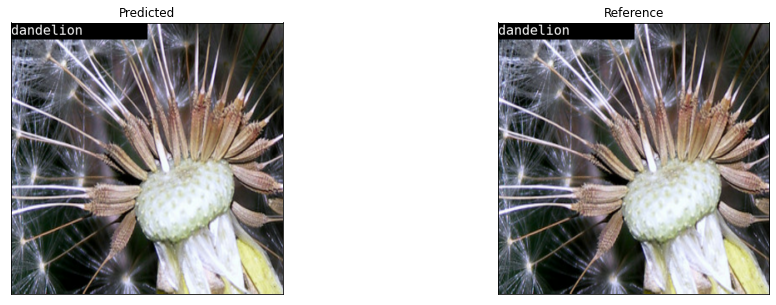

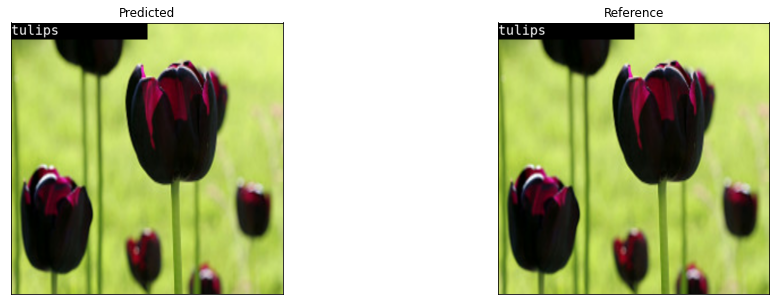

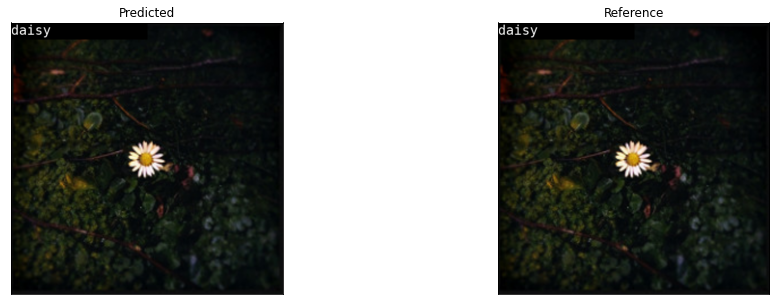

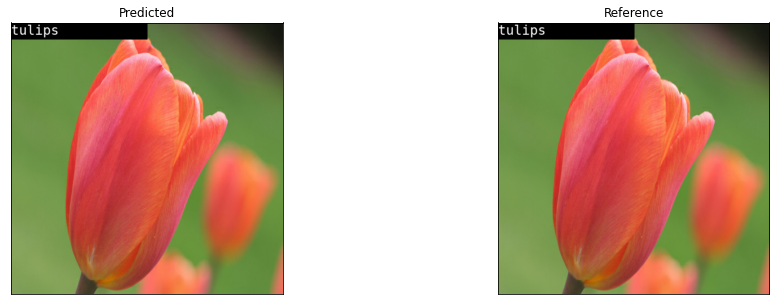

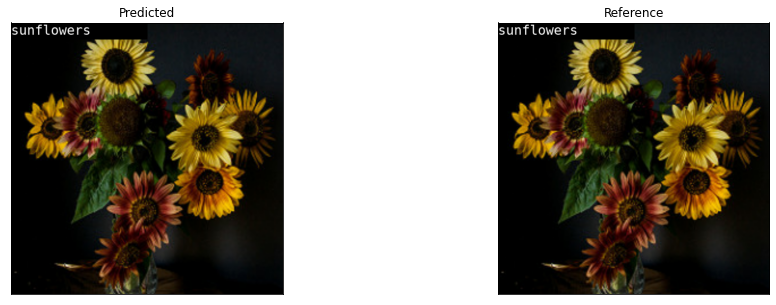

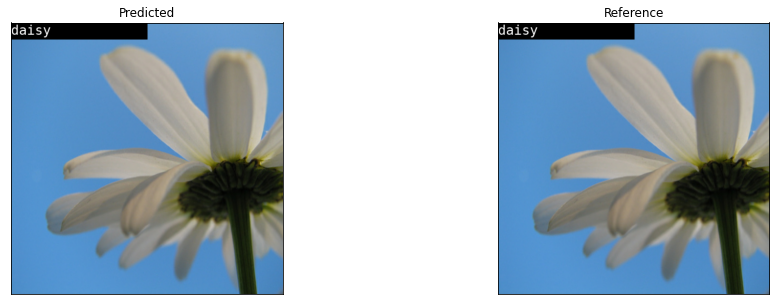

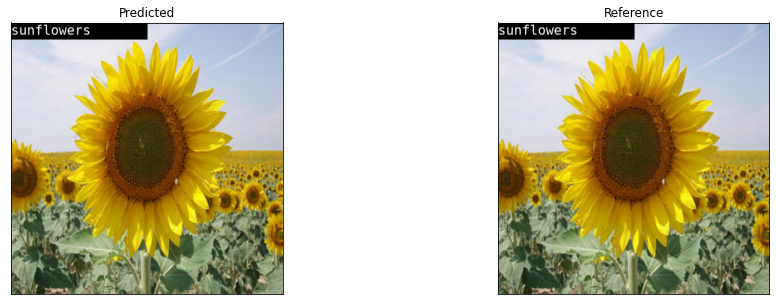

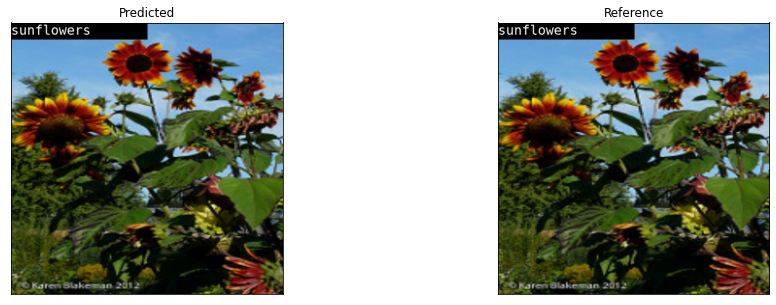

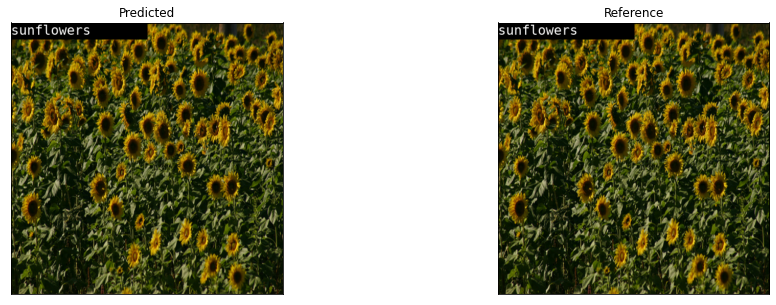

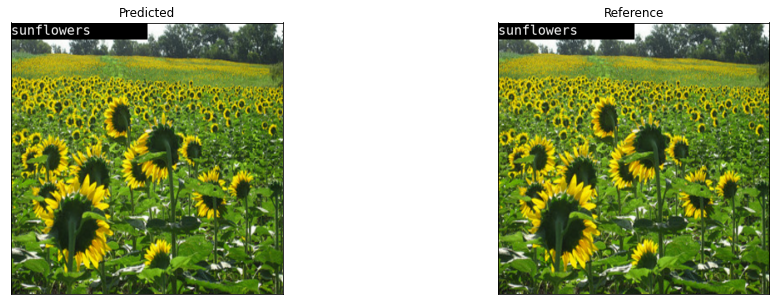

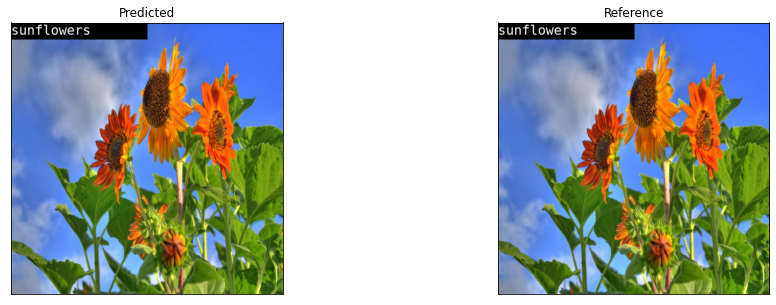

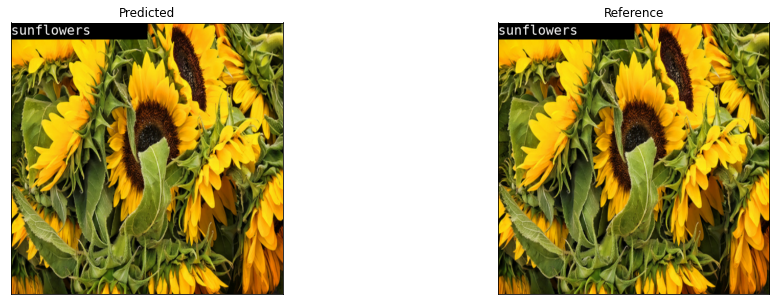

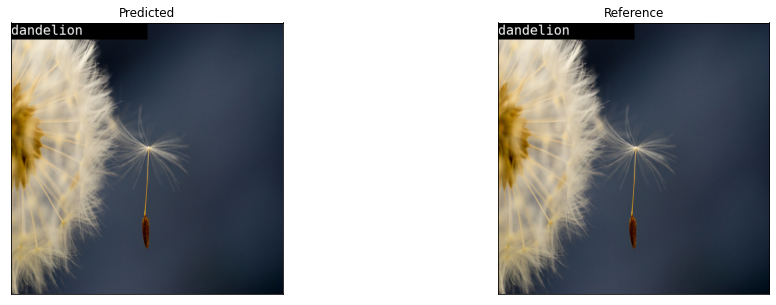

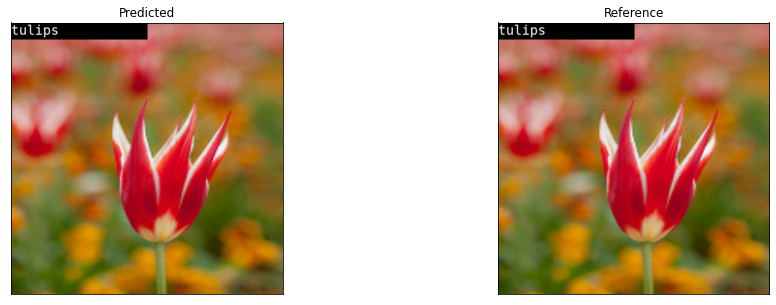

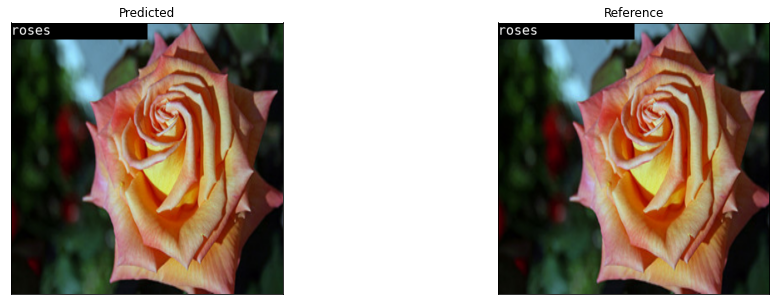

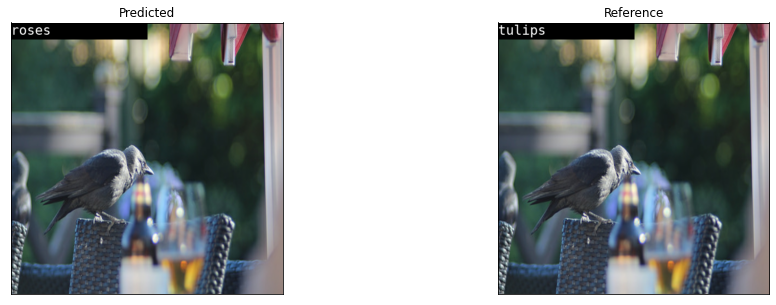

In [13]:
dl.show_results(model, 16)